# 예측값 도출

In [1]:
# 라이브러리 호출
import json
import os

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

2023-07-21 04:49:07.731730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 04:49:07.837261: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-21 04:49:08.372291: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/chms/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64:
2023-07-21 0

In [2]:
oil_data_path = 'oiltank_dataset/valid_images'
container_data_path = 'container_dataset/valid_images'

## selective search

In [3]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [4]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [5]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [6]:
model = tf.keras.models.load_model('VGG16')

2023-07-21 04:49:11.319703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 04:49:12.193139: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22269 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2023-07-21 04:49:12.194149: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21820 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [7]:
for i in os.listdir(oil_data_path):
    if i[-3:] != 'png':
        os.remove(oil_data_path + f'/{i}')

for i in os.listdir(container_data_path):
    if i[-3:] != 'png':
        os.remove(container_data_path + f'/{i}')

In [13]:
# test set 생성
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_data_generator = ImageDataGenerator(rescale=1. / 255)
test_dataset = test_data_generator.flow_from_directory('tmp',
                                                         shuffle=True,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='categorical')

Found 707 images belonging to 1 classes.


In [14]:
from collections import Counter

tmp = model.predict(test_dataset)
ans = []
for i in tmp:
    ans.append(np.argmax(i))

ans = Counter(ans)
ans

23/23 [==============================] - 1s 43ms/step


Counter({28: 677, 7: 1, 12: 2, 10: 10, 13: 10, 1: 4, 16: 3})

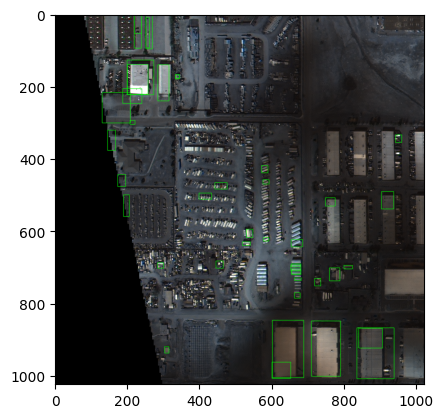

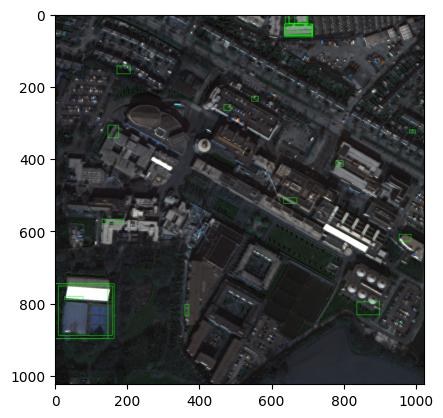

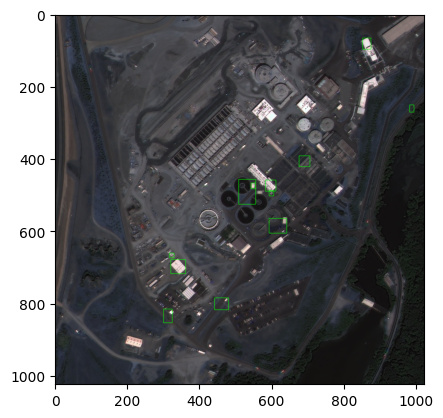

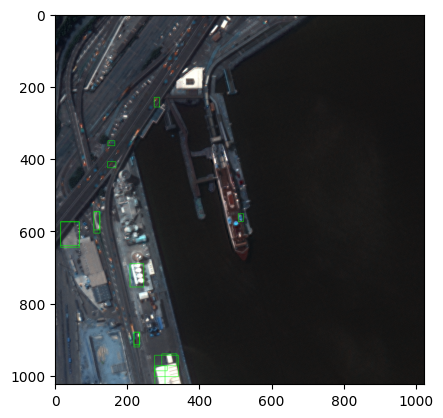

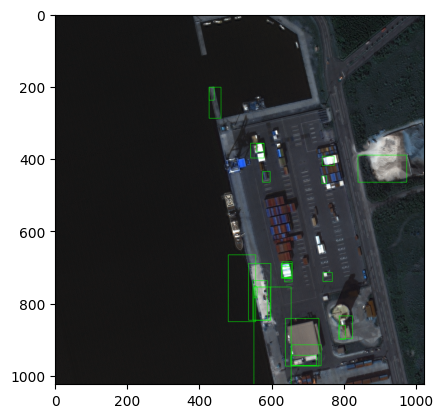

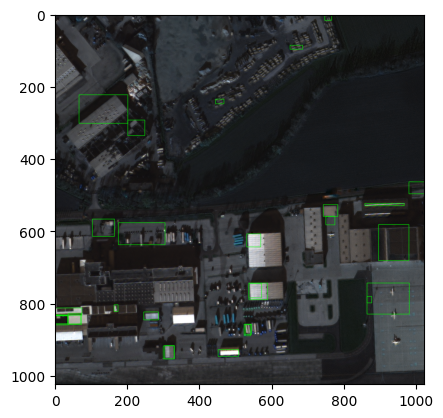

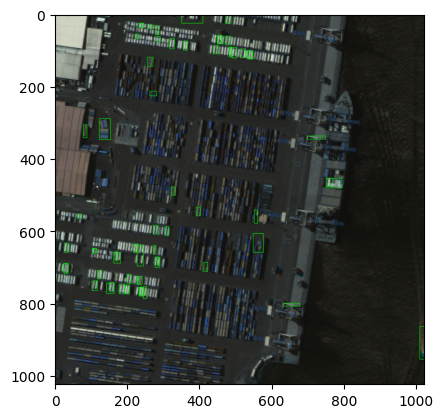

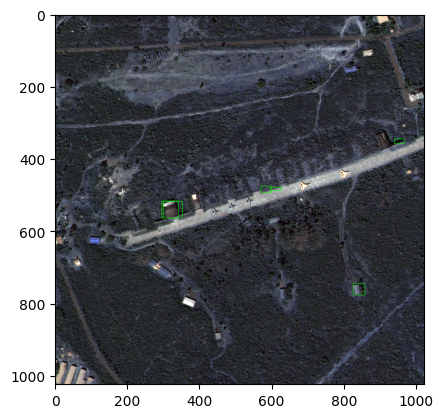

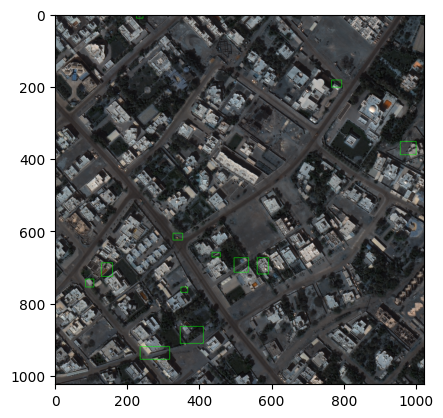

In [19]:
for e,i in enumerate(os.listdir(container_data_path)[1:10]):
    img = cv2.imread(os.path.join(container_data_path,i))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = img.copy()
    for e,result in enumerate(ssresults):
        tmp = []
        if e < 2000:
            x,y,w,h = result
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out= model.predict(img, verbose=0)
            if np.argmax(out) == 28:
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    plt.figure()
    plt.imshow(imout)
    plt.show()



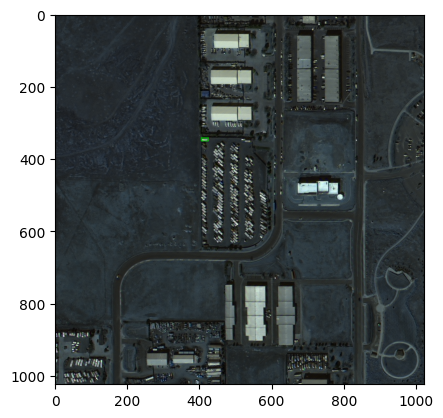

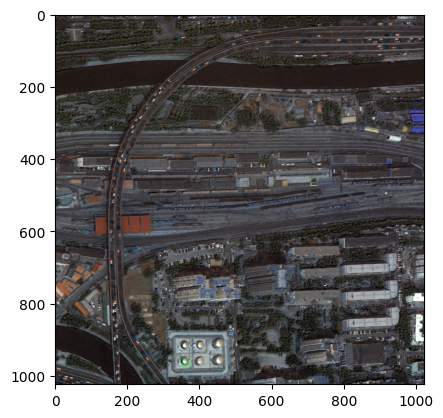

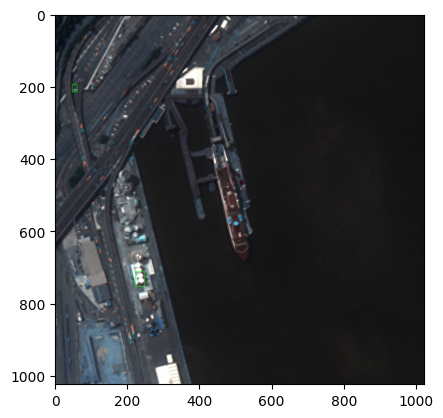

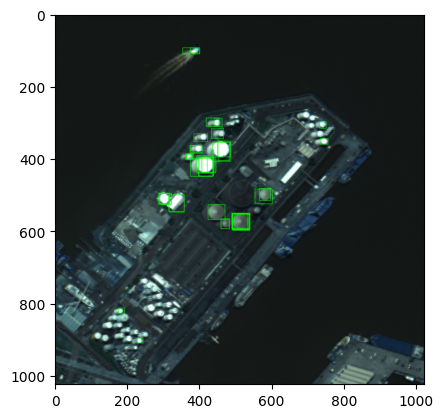

KeyboardInterrupt: 

In [18]:
for e,i in enumerate(os.listdir(oil_data_path)[:10]):
    img = cv2.imread(os.path.join(oil_data_path,i))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = img.copy()
    for e,result in enumerate(ssresults):
        tmp = []
        if e < 2000:
            x,y,w,h = result
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out= model.predict(img, verbose=0)
            if np.argmax(out) == 29:
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    plt.figure()
    plt.imshow(imout)
    plt.show()



In [ ]:
for e,i in enumerate(os.listdir(oil_data_path)):
    img = cv2.imread(os.path.join(oil_data_path,i))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = img.copy()
    for e,result in enumerate(ssresults):
        tmp = []
        if e < 2000:
            x,y,w,h = result
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out= model.predict(img, verbose=0)
            if out[0][1] > 0.65:
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)